# $t \bar{t}$ background analysis (PHYSLITE files) for the SRD

In [1]:
# Import basic libraries
import os   

import uproot   
import awkward as ak    
import vector   
vector.register_awkward()
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

Btw, momenta etc. in these files are given in MeVs. So, everytime you put a cut or something on a dimensionful quantity, multiply the cut with GeV:

In [2]:
GeV = 1000.

In this notebook we are using a dataset from `mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_p5855`. To run this notebook locally, please download a dataset from this container and substitute the file and path in the `filename` variable below.

In [3]:
# mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_p5855
#filename = "DAOD_PHYSLITE.34865537._000312.pool.root.1"

#We have this file:
firstFile = '/home/armanubuntu/DAOD_PHYSLITE.37620644._000012.pool.root'

In [4]:
treeFile = uproot.open({firstFile: "CollectionTree"}) 

In [5]:
GeV = 1000.

In [6]:
#print(f'Number of electrons before selection: {ak.count(electrons.pt):,}')
#print(f'Number of electrons after selection: {ak.count(events.Electrons.pt):,}')

# Run 

When scaling up data analysis to handle larger datasets, especially in high-energy physics where datasets can be enormous, managing memory usage becomes crucial to prevent running out of memory (OOM) errors. Here's a clearer explanation of the strategies mentioned for handling large-scale data processing efficiently:

#### Chunking the Processing
This approach involves dividing the dataset into smaller, manageable pieces or "chunks" and processing each chunk sequentially. After processing a chunk, the results can be aggregated (e.g., accumulating in a histogram or ntuple), and the memory used by the chunk can be released before moving on to the next chunk. This method helps in managing memory usage effectively by ensuring that only a portion of the data is held in memory at any given time.

- Advantages: Simple to implement and can significantly reduce memory usage.
- Use Case: Particularly useful when operations on individual chunks are independent and can be aggregated easily.

#### Distributed Processing
Distributed processing involves spreading the data and computations across multiple machines or processors. This not only helps in managing memory by leveraging the collective memory of multiple systems but also can speed up the processing by executing tasks in parallel. We won't discuss distributed processing in this tutorial, but there are nice possibilities to do this while still staying interactive by using [`dask`](https://www.dask.org/)

#### Processing Data in Chunks with Awkward Array
For the specific case of processing large datasets of particle physics events, where the analysis might discard a significant number of events and only a subset of data columns are retained, processing data in chunks becomes highly efficient. Here's how you can do it:

- **Process Each File Separately**: Instead of loading the entire dataset into memory, process each file one at a time. This limits the amount of data in memory to what's contained in a single file.
- **Use `ak.to_packed` for Memory Efficiency**: After applying event selection and filtering out unnecessary data, the ak.to_packed function can be used to further reduce memory usage. This function optimizes the memory layout of the Awkward Array by eliminating unused spaces (from masks and indices) and ensuring that only the memory needed for the retained data is used.

#### Organize code into functions
First, we structure everything a bit more nicely into functions

##### Defining a Schema
The schema dictionary outlines the data structure expected from the input files. It maps each particle type (Electrons, Muons, Jets, and BTagging information) to the relevant attributes that will be read and processed. This schema is crucial for dynamically handling different data fields across various particle types.

In [7]:
schema = {
    "Electrons": [
        "pt", "eta", "phi",
    ],

    "Muons": [
        "pt", "eta", "phi",
    ],

    "TauJets": [
        "pt", "eta", "phi",
    ],

    "Jets": [
        "pt", "eta", "phi", "m", "JVFCorr", 
        #"NumTrkPt500", # - later on added, since the quantity has a couple of columns which we don't need
        # "DFCommonJets_fJvt" is the forward JVT score, which is not needed. This is not JVT! Check https://arxiv.org/pdf/1705.02211 and https://arxiv.org/pdf/1510.03823
    ],

    "BTagging_AntiKt4EMPFlow": [
        "DL1dv01_pb",
    ],

    "Photons": [
        "pt", "eta", "phi",
    ],

    "MET_Core_AnalysisMET": [
        "mpx", "mpy", "sumet", "name",
    ]
}

In [8]:
schema.items()

dict_items([('Electrons', ['pt', 'eta', 'phi']), ('Muons', ['pt', 'eta', 'phi']), ('TauJets', ['pt', 'eta', 'phi']), ('Jets', ['pt', 'eta', 'phi', 'm', 'JVFCorr']), ('BTagging_AntiKt4EMPFlow', ['DL1dv01_pb']), ('Photons', ['pt', 'eta', 'phi']), ('MET_Core_AnalysisMET', ['mpx', 'mpy', 'sumet', 'name'])])

We define functions (selected_electrons, selected_muons, selected_jets) to encapsulate the selection logic. These functions return only the particles from each event that meet both conditions:
- Their $p_T$ is greater than a certain value (for different objects, it's a different cut).
- Their $\eta$ is within a certain range, ensuring they are centrally located within the detector.
- For jets, it is important to take into account some measure that differentiates between hard-scattering jets and jets emerging from pile-up. For this, we use the corrJVF quantity (note that fJVT, present in PHYSLITE format, IS NOT THE SAME AS JVT, which is a quantity taken in the ATLAS experimental paper. corrJVF resembles much more JVT than fJVT does).


In [9]:
def selected_electrons(el):
    return el[(el.pt > 7 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 6 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets_events(j):
    return j[((j.pt > 60 * GeV) & (abs(j.eta) < 2.80)) | ((j.pt > 20 * GeV) & (j.pt < 60 * GeV) & (abs(j.eta) < 2.80) & (abs(j.eta) > 2.40)) | ((j.pt > 20 * GeV) &  (j.pt < 60 * GeV) & (abs(j.eta) < 2.40) & (j.JVFCorr > 0.5))] 

def selected_jets_MET(j): #There is an additional part of the phase-space that is taken into account for the jets, in the MET calculation
    return j[((j.pt > 60 * GeV) & (abs(j.eta) < 4.50)) | ((j.pt > 20 * GeV) & (j.pt < 60 * GeV) & (abs(j.eta) < 4.50) & (abs(j.eta) > 2.40)) | ((j.pt > 20 * GeV) &  (j.pt < 60 * GeV) & (abs(j.eta) < 2.40) & (j.JVFCorr > 0.5))] 


def selected_photons(p): # Define the photon objects according to the ATLAS experimental paper for the MET calculation. We will not need them in later stages of the analysis
    return p[((p.pt > 25 * GeV) & (abs(p.eta) < 1.37)) | ((p.pt > 25 * GeV) & (abs(p.eta) > 1.52) & (abs(p.eta) < 2.37))]

# The pT has to be larger than 25 GeV, eta has to be either less than 1.37 or between (1.52, 2.37)

Not completely sure about the $\tau_{\rm had}$ definition, because no info is available in the ATLAS experimental paper.
Use the definition of https://arxiv.org/pdf/1802.08168 for the $\tau_{\rm had}$ jets:

In [10]:
def selected_tau(tau): 
    return tau[((tau.pt > 20 * GeV) & (abs(tau.eta) < 1.37)) | ((tau.pt > 20 * GeV) & (abs(tau.eta) > 1.52) & (abs(tau.eta) < 2.37))]

#### Overlap removal

Overlap removal is an essential step in particle physics analyses to ensure that the same physical object is not misidentified as multiple types of particles. When particles like electrons and jets are detected close to each other in the detector, it can create ambiguity about their identities. This section explains how to identify and remove such overlaps, focusing on the overlap between electrons and jets.

##### Understanding Overlap Removal
1. **Identifying Overlaps with Cartesian Product**:

    The process begins by considering all possible pairs (combinations) of electrons and jets within each event. This is known as creating a Cartesian product.
    `ak.cartesian([events.Jets, events.Electrons], nested=True)` generates all combinations of jets and electrons. The `nested=True` parameter adds an additional dimension to the array, which represents each possible pair of jet and electron. 

    The result of `ak.cartesian` is then split into two arrays (`jj` for jets and `ee` for electrons) using `ak.unzip`. This effectively separates the pairs into corresponding jets and electrons arrays but keeps them linked by their indices within these arrays.

2. **Calculating the Separation with $\Delta R$**:

    The next step involves calculating the separation between each jet-electron pair. This separation is quantified using a metric called $\Delta R$, which combines differences in their azimuthal angle ($\phi$) and pseudorapidity ($\eta$) into a single distance measure. `jj.deltaR(ee)` calculates the $\Delta R$ between each jet and electron in the pairs generated. Plotting the histogram of $\Delta R$ values for all jet-electron pairs gives insight into how closely jets and electrons are located to each other in the detector.

In [11]:
def no_overlap_electrons(obj1, obj2, deltaR=0.2): # mask for each JET if it has no overlap with any electron
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def no_overlap_muons(obj1, obj2, deltaR=0.2): # mask for each JET if it has no overlap with any muon
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(((obj1.deltaR(obj2) > deltaR) | (obj1.NumTrkPt500 >= 3)), axis=-1) #modified


def no_overlap_muons_noTrk(obj1, obj2, deltaR=0.2): # mask for each JET if it has no overlap with any muon
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))    
    return ak.all((obj1.deltaR(obj2) > deltaR), axis=-1)


def remove_leptons_final(obj1, obj2): # Mask for each LEPTON if they are too close to a jet
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))

    # Calculate the dynamic threshold
    threshold = ak.where(0.04 + (10. / (obj1.pt * GeV)) < 0.4, 0.04 + (10. / (obj1.pt * GeV)), 0.4) #ak.where takes care of an element-wise comparison!

    return ak.all(obj1.deltaR(obj2) > threshold, axis=-1)


The function that tells us the value of $\mathrm{min} \big[\Delta \phi (\mathbf{p}_T^{\rm miss}, \mathbf{p}_T^{j_{1,2,3}}) \big] $ (returning one  value for each event). Later on we will add this quantity to the Awkward array - since it's needed for the BDT!

In [12]:
def deltaPhi_MET_j(obj1, obj2): 
    obj1, obj2 = ak.unzip(ak.cartesian([obj1[:, 0:3], obj2], nested=True)) # Note that this cutting is not a problem. If we sometimes have only 1 jet, then this will not introduce any errors

    # The function deltaPhi is giving results from -pi to pi. So, take the abs value of the negative angles!
    # Take only the first three jets ( = the three jets with the highest PT), check the phi angles between them, take the smallest one.
    
    delPhiMin =  ak.min(np.abs(obj1.deltaphi(obj2)), axis = 1)
    
    return ak.flatten(delPhiMin, axis = 1)

Maybe build a function for calculating $\Delta \phi_{bb}$?

In [13]:
# Make a function that will calculate the angle between the first and second bjet for each event

def deltaphib_bbar(obj1, obj2):

    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True)) # Note that this cutting is not a problem. If we sometimes have only 1 jet, then this will not introduce any errors

    phi = ak.flatten(np.abs(obj1.deltaphi(obj2)), axis = 1) 

    if phi > np.pi:
        phi = 2*np.pi - phi 

    return phi

##### `read_events` Function
Reads data from a file according to the specified schema, organizing the data into a structured format suitable for analysis.

**Process:**
- Opens a file using uproot and iterates over the schema to read specified fields for each particle type.
- Uses `ak.zip` to combine the fields into structured arrays, preserving the relationship between different attributes of each particle type.
- Returns a structured awkward array (`ak.zip(events, depth_limit=1)`) that encapsulates the event data, allowing for efficient, high-level operations on the dataset.

In [14]:
def read_events(rootTree, schema):
    events = {}
    for objname, fields in schema.items():
        base = objname
        if objname in ["Electrons", "Muons", "Jets", "Photons", "TauJets"]:
            base = "Analysis" + objname
            ak_zip = vector.zip
        else:
            ak_zip = ak.zip
        arrays = rootTree.arrays(
            fields, 
            aliases={field: f"{base}AuxDyn.{field}" for field in fields},
        )
        arrays = ak_zip(dict(zip(arrays.fields, ak.unzip(arrays))))
        events[objname] = arrays
    
    return ak.zip(events, depth_limit=1)

In [15]:
treeFile["AnalysisJetsAuxDyn.NumTrkPt500"].array()[:,:,0]

<Array [[6, 6, 5, 5, 3, 3, 4], ..., [11, ..., 0]] type='160000 * var * int32'>

## Testing and playing a bit

In [16]:
events = read_events(treeFile, schema)

In [17]:
# Since it seems we only need the soft MET contribution from the ID tracks, build a mask:
id_MET_mask = events["MET_Core_AnalysisMET"].name == "PVSoftTrkCore"

# Use it in the following way:
# ak.flatten(events["MET_Core_AnalysisMET"][id_MET_mask].mpy)

In [18]:
ak.sum(events["MET_Core_AnalysisMET"][id_MET_mask].mpx, axis = 1)

<Array [-2.33, -1.78e+03, ..., 1.39e+04, -2.98e+03] type='160000 * float32'>

### A couple of distributions plotted:

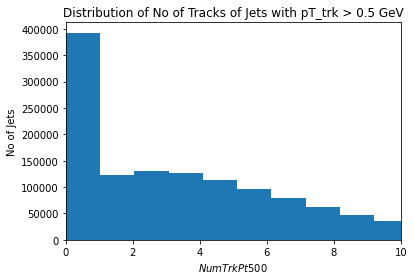

In [19]:
plt.hist(ak.flatten(treeFile["AnalysisJetsAuxDyn.NumTrkPt500"].array()[:,:,0], axis=1).to_numpy(), bins=45, density=False)
plt.xlabel("$NumTrkPt500$")
plt.xlim(0,10)
plt.ylabel("No of Jets")
plt.title('Distribution of No of Tracks of Jets with pT_trk > 0.5 GeV')
plt.show()


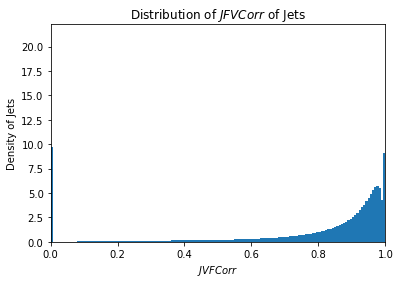

In [20]:
plt.hist(ak.flatten(events.Jets.JVFCorr, axis=1).to_numpy(), bins=300, density=True)
plt.xlabel("$JVFCorr$")
plt.xlim(0,1)
plt.ylabel("Density of Jets")
plt.title('Distribution of $JFVCorr$ of Jets')
plt.show()

In [21]:
print("High-pT jets:", np.sum((events.Jets.pt > 60 * GeV) & (abs(events.Jets.eta) < 2.80)))
print("Medium-pT, high eta:", np.sum((events.Jets.pt > 20 * GeV) & (events.Jets.pt < 60 * GeV) & (abs(events.Jets.eta) < 2.80) & (abs(events.Jets.eta) > 2.40)))
print("Medium-pT, low eta, corrJVF < 0.5:", np.sum((events.Jets.pt > 20 * GeV) & (events.Jets.pt < 60 * GeV) & (abs(events.Jets.eta) < 2.40) & (events.Jets.JVFCorr < 0.5)))
print("Medium-pT, low eta, corrJVF > 0.5:", np.sum((events.Jets.pt > 20 * GeV) & (events.Jets.pt < 60 * GeV) & (abs(events.Jets.eta) < 2.40) & (events.Jets.JVFCorr > 0.5)))
print("No of events:", len(events.Jets))

High-pT jets: 311805
Medium-pT, high eta: 34484
Medium-pT, low eta, corrJVF < 0.5: 25601
Medium-pT, low eta, corrJVF > 0.5: 422059
No of events: 160000


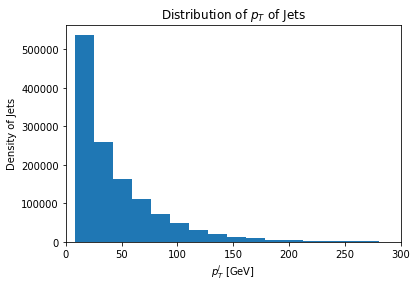

In [22]:
plt.hist(ak.flatten(events.Jets.pt, axis=1).to_numpy()/1000., bins=75, density=False)
plt.xlabel("$p^j_T$ [GeV]")
plt.xlim(0, 300)
plt.ylabel("Density of Jets")
plt.title('Distribution of $p_T$ of Jets')
plt.show()

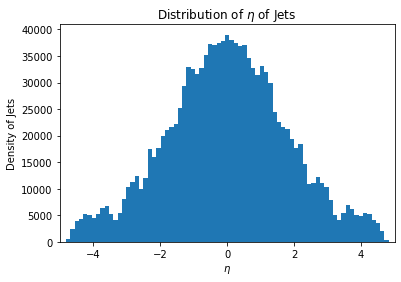

In [23]:
plt.hist(ak.flatten(events.Jets.eta, axis=1).to_numpy(), bins=75, density=False)
plt.xlabel("$\eta$")
plt.xlim(-5, 5)
plt.ylabel("Density of Jets")
plt.title('Distribution of $\eta$ of Jets')
plt.show()

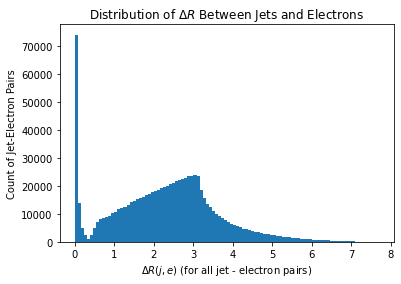

In [24]:
jj, ee = ak.unzip(ak.cartesian([events.Jets, events.Electrons], nested=True))
plt.hist(ak.flatten(jj.deltaR(ee), axis=None).to_numpy(), bins=100)
plt.xlabel("$\Delta R(j, e)$ (for all jet - electron pairs)")
plt.ylabel("Count of Jet-Electron Pairs")
plt.title('Distribution of $\Delta R$ Between Jets and Electrons')
plt.show()

The plot for $\Delta \phi$:

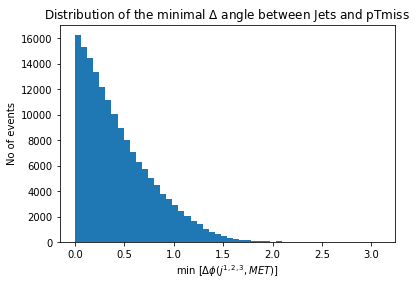

In [25]:
events["MET_x"] = ak.sum(events.Jets.px, axis = 1) + ak.sum(events.Electrons.px, axis = 1) + ak.sum(events.Muons.px, axis = 1) + ak.sum(events.TauJets.px, axis = 1) + ak.sum(events.Photons.px, axis = 1) + ak.sum(events["MET_Core_AnalysisMET"][id_MET_mask].mpx, axis = 1)
events["MET_y"] = ak.sum(events.Jets.py, axis = 1) + ak.sum(events.Electrons.py, axis = 1) + ak.sum(events.Muons.py, axis = 1) + ak.sum(events.TauJets.py, axis = 1) + ak.sum(events.Photons.py, axis = 1) + ak.sum(events["MET_Core_AnalysisMET"][id_MET_mask].mpy, axis = 1)


met_vector = vector.awk(ak.zip({"px": events.MET_x, "py": events.MET_y}))


jj, metvec = ak.unzip(ak.cartesian([events.Jets[:, 0:3], met_vector], nested=True))
plt.hist(ak.min(np.abs(jj.deltaphi(metvec)), axis = 1).to_numpy(), bins=50)
plt.xlabel("min [$ \Delta \phi (j^{1,2,3}, MET)$]")
plt.ylabel("No of events")
plt.title('Distribution of the minimal $\Delta \varphi$ angle between Jets and pTmiss')
plt.show()


Checking the different overlap removals with the muon (with or without the $N_{\rm trk}$ requirement):

In [26]:
np.sum(ak.num(events.Jets))

1292155

In [27]:
np.sum(ak.flatten(no_overlap_muons_noTrk(events.Jets, events.Muons)))

1240778

It makes sense, we are only targeting jets that are inside $\Delta R = 0.2$ of a muon AND have $N_{\rm trk} < 3$. So that's a very specific subset of jets. Needless to say, it's not a lot of them anyway.

In [28]:
events["Electrons"] = events.Electrons[remove_leptons_final(events.Electrons, events.Jets)]

The soft contribution to the MET:

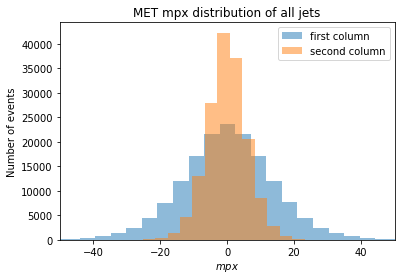

In [29]:
MET_mpx = treeFile["MET_Core_AnalysisMETAuxDyn.mpx"].array()
#MET_mpx_np = ak.flatten(MET_mpx).to_numpy()
#MET_mpx_np = MET_mpx_np/1000


plt.hist(MET_mpx[:,0].to_numpy()/1000, bins=50, label = 'first column', alpha = 0.5)
plt.hist(MET_mpx[:,1].to_numpy()/1000, bins=50, label = 'second column', alpha = 0.5)
plt.title('MET mpx distribution of all jets')
plt.xlabel('$mpx$')
plt.xlim(-50, 50)
plt.ylabel('Number of events')
plt.legend()
plt.show()

In [30]:
treeFile["MET_Core_AnalysisMETAuxDyn.name"].array()

<Array [['SoftClusCore', ...], [...], ..., [...]] type='160000 * var * string'>

## Processing the events

##### `processed` Function
Applies a series of processing steps to the events data to prepare it for analysis. This includes applying selection criteria and organizing data for efficient memory usage.

**Process:**
- Makes a shallow copy of the events to avoid mutating the original data.
- Adds a `btag_prob` field to Jets based on BTagging information.
- Applies selection functions (`selected_electrons`, `selected_muons`, `selected_jets`) to filter particles based on specific criteria (e.g., transverse momentum and pseudorapidity).
- Removes overlapping jets with selected electrons to avoid double counting.
- Flags jets as b-tagged jets (`is_bjet`) based on their b-tagging probability.
- Applies event selection criteria to filter the events further, retaining those with two or three jets, zero leptons (electron or muon), and at least two b-tagged jets.
- Compacts the data using ak.`to_packed` to reduce memory usage, discarding unnecessary indices and masks.

It returns a processed and compacted dataset, ready for further analysis, with significantly reduced memory footprint.

In [31]:
def processed(events):
  # events = copy.copy(events) # shallow copy, to not edit the original events

  # Add a btag_prob and is_bjet column
  
  #events["Jets", "btag_prob"] = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb # This array is a bit problematic for pandas. Anyway, we don't need it afterwards
  #events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.77

  btag_prob_jets = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb
  events["Jets", "is_bjet"] = btag_prob_jets > 0.77

  
  # Define jets that will be used in the further analysis, and jets that will be used for the MET calculation (not the same!)
  events["Jets"] = selected_jets_events(events.Jets)
  events["Jets_MET"] = selected_jets_MET(events.Jets)
  
  # Define the baseline leptons (satisfying simple pT and eta requirements defined above)
  events["Electrons"] = selected_electrons(events.Electrons)
  events["Muons"] = selected_muons(events.Muons)
  
  # Define the tauJets 
  events["TauJets"] = selected_tau(events.TauJets)
  
  # Remove jets that overlap with electrons
  events["Jets"] = events.Jets[no_overlap_electrons(events.Jets, events.Electrons)] # mask for each jet if it has overlap with any electron
  
  # Remove jets that overlap with muons
  events["Jets"] = events.Jets[no_overlap_muons(events.Jets, events.Muons)]

  # Finally, remove the leptons (the third overlap criterion mentioned in the ATLAS paper)
  
  events["Electrons"] = events.Electrons[remove_leptons_final(events.Electrons, events.Jets)]
  events["Muons"]     = events.Muons[remove_leptons_final(events.Muons, events.Jets)]
  
  # Calculate the missing transverse energy. Get the x and y coordinate separately (needs to be a VECTOR sum). axis=1 means to sum in the event, not everything
  # Since the number of jets, electrons, muons differ between themselves in each event, first we sum each of them independently
  
  met_x = ak.sum(events.Jets_MET.px, axis = 1) + ak.sum(events.Electrons.px, axis = 1) + ak.sum(events.Muons.px, axis = 1) + ak.sum(events.TauJets.px, axis = 1) + ak.sum(events.Photons.px, axis = 1) + ak.sum(events["MET_Core_AnalysisMET"][id_MET_mask].mpx, axis = 1)
  met_y = ak.sum(events.Jets_MET.py, axis = 1) + ak.sum(events.Electrons.py, axis = 1) + ak.sum(events.Muons.py, axis = 1) + ak.sum(events.TauJets.py, axis = 1) + ak.sum(events.Photons.py, axis = 1) + ak.sum(events["MET_Core_AnalysisMET"][id_MET_mask].mpy, axis = 1)
  
  # Define the MET vector, from which we can then get variables like pt = ETmiss and phi
  met_vector = vector.awk(ak.zip({"px": met_x, "py": met_y}))
  events["MET"] = met_vector.pt

  # Now we can assign the minDeltaPhi to each event (Not to each jet)
  events["minDeltaPhi"] = deltaPhi_MET_j(events.Jets, met_vector)

  # Define HT, which is the scalar sum of the pTs of jets in an event:
  events["HT"] = ak.sum(events.Jets_MET.pt, axis = 1)
  
  events["ptj1"] = ak.firsts(events.Jets.pt, axis = 1, highlevel=True)
  events["ptj1_x"] = ak.firsts(events.Jets.px, axis = 1, highlevel=True) # Hope this works
  events["ptj1_y"] = ak.firsts(events.Jets.py, axis = 1, highlevel=True)
  events["mj1"] = ak.firsts(events.Jets.m, axis = 1, highlevel=True)
  
  # Finally, we need the pT(j1)/HT array (for the cut and BDT)

  events["ptj1_over_HT"] = events.ptj1/events.HT

  # Get the value for pT(b1) - Needed by the BDT
  events["ptb1"] = ak.firsts(events.Jets[events.Jets.is_bjet].pt, axis = 1, highlevel=True)
  
  # To get the second jet, we have tried a lot of methods, but this is the only one that works for some reason inside this function
  
  every_second_jet = events.Jets[:, 1:]


  events["ptj2"] = ak.firsts(every_second_jet.pt, axis = 1, highlevel=True)
  events["ptj2_x"] = ak.firsts(every_second_jet.px, axis = 1, highlevel=True)
  events["ptj2_y"] = ak.firsts(every_second_jet.py, axis = 1, highlevel=True)
  events["mj2"] = ak.firsts(every_second_jet.m, axis = 1, highlevel=True)


  # Similarly for the third jet
  every_third_element = events.Jets.pt[:, 2:]
  events["ptj3"] = ak.firsts(every_third_element, axis = 1, highlevel=True)

  # Let us also take into consideration the fake S_MET, with \sqrt{HT} as the denominator
  events["S_MET"] = events.MET/np.sqrt(events.HT)

  # Now the angle between the first and second b-jet
  first_b_jets_phi = ak.firsts(events.Jets[events.Jets.is_bjet].phi, axis = 1, highlevel=True)
  #Switch the "None" to 0. Do not worry about the results of these events, because we anyway ask for 2 b-jets in the analysis. So whatever we get in this event, it will be discarded!
  #We have to do this because 
  first_b_jets_phi = ak.fill_none(first_b_jets_phi, value = 0)  

  every_second_b_jet = events.Jets[events.Jets.is_bjet][:, 1:]
  second_b_jets_phi = ak.firsts(every_second_b_jet.phi, axis = 1, highlevel=True)
  second_b_jets_phi = ak.fill_none(second_b_jets_phi, value=0)


  events["deltaPhi_bb"] = np.abs(first_b_jets_phi - second_b_jets_phi) # Now it can be from 0 to 2pi. However, if it is bigger than pi, we need to subtract pi
  events["deltaPhi_bb"] = events.deltaPhi_bb - ak.where(events.deltaPhi_bb > np.pi, np.pi, 0)


  #jetsPT1 = ak.Array(events.Jets.pt[:,0]) # This not working in the loop??? But outside it's fine... maybe 0:1 was the thing
  
  # Delta minus

  events["delta_minus"] = events.minDeltaPhi - events.deltaPhi_bb 


  # Delta plus
  events["delta_plus"] = np.abs(events.deltaPhi_bb + events.minDeltaPhi - ak.full_like(events.minDeltaPhi, np.pi*1)) # With ak, you cannot simply write - np.pi and expect the array substraction will include -np.pi, i.e. -np.pi*[1,1,...,1]

  #Contransverse mass 

  eT_j1 = np.sqrt(events.ptj1**2 + events.mj1**2)
  eT_j2 = np.sqrt(events.ptj2**2 + events.mj2**2)
  events["mCTj1j2"] = np.sqrt((eT_j1 + eT_j2)**2 - (events.ptj1_x - events.ptj2_x)**2 - (events.ptj1_y - events.ptj2_y)**2)

  
  # Create the Pandas DataFrame now. Turns out, Pandas is very much linked to NumPy so not to produce errors, transform all of these arrays to NP arrays
  # The factors of 1000 are to transform the MeV quantities into GeV
  
  df_events = pd.DataFrame(
    np.array(np.transpose([
    ak.to_numpy(events["MET"], allow_missing=True)/1000., ak.to_numpy(events["S_MET"], allow_missing=True)/np.sqrt(1000.), 
    ak.to_numpy(events["HT"], allow_missing=True)/1000., ak.to_numpy(events["ptj1_over_HT"], allow_missing=True), 
    ak.to_numpy(events["ptb1"], allow_missing=True)/1000., ak.to_numpy(events["ptj2"], allow_missing=True)/1000., 
    ak.to_numpy(events["ptj3"], allow_missing=True)/1000., ak.to_numpy(events["minDeltaPhi"], allow_missing=True),
    ak.to_numpy(events["deltaPhi_bb"], allow_missing=True), ak.to_numpy(events["delta_minus"], allow_missing=True), 
    ak.to_numpy(events["delta_plus"], allow_missing=True), ak.to_numpy(events["mCTj1j2"], allow_missing=True)/1000.])),
    columns=['MET', 'S', 'HT', 'HTratio', 'pT(b1)', 'pT(j2)', 'pT(j3)', 'Delta Phi (MET, j_{1,2,3})', 'DeltaPhi(bb)', 'delta-', 'delta+', 'mCTj1j2'])


  
  # Put the cuts

  df_events = df_events[ak.to_numpy(
      (events.MET > 180 * GeV) # the MET has to be larger than 180 GeV
      & (ak.num(events.Jets) > 1) # at least 2 jets
      & (ak.num(events.Jets) < 4) # and no more than 3 jets
      & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 0) # no baseline leptons
      & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.77
      & (events.minDeltaPhi > 0.4) #the minimum angle is indeed greater than 0.4 
      & (events.ptj1 > 100 * GeV) # the most energetic jet pt has to be larger than 100 GeV
      & (events.ptj2 > 50 * GeV) # the second most energetic jet pt has to be larger than 50 GeV
      & (events.ptj1_over_HT > 0.7), # The ratio between pT(j1)/HT should be larger than 0.7
      allow_missing=True) # We need to transform these to a Numpy array, and also allow for missing events, so the dimensions are the same
  ]


  # We can also remove some of the arrays that we will not need anymore with delitem:

  #df_events.drop(columns=["ptj1_x", "ptj1_y", "mj1", "ptj2_x", "ptj2_y", "mj2"], inplace=True)

  #return ak.to_packed(events)

  return df_events
  


## Post-processing

Translate to a Pandas DataFrame:

In [32]:
# df_ttbar_events = processed(events)
# df_ttbar_events

# Final code: setting in a loop

In [ ]:

# THE REAL LIST OF FILES:

rootfiles = [
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000012.pool.root.1 DAOD_PHYSLITE.37620644._000012.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000013.pool.root.1 DAOD_PHYSLITE.37620644._000013.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000014.pool.root.1 DAOD_PHYSLITE.37620644._000014.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000015.pool.root.1 DAOD_PHYSLITE.37620644._000015.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000017.pool.root.1 DAOD_PHYSLITE.37620644._000017.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000018.pool.root.1 DAOD_PHYSLITE.37620644._000018.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000019.pool.root.1 DAOD_PHYSLITE.37620644._000019.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000021.pool.root.1 DAOD_PHYSLITE.37620644._000021.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000023.pool.root.1 DAOD_PHYSLITE.37620644._000023.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000024.pool.root.1 DAOD_PHYSLITE.37620644._000024.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000025.pool.root.1 DAOD_PHYSLITE.37620644._000025.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000026.pool.root.1 DAOD_PHYSLITE.37620644._000026.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000028.pool.root.1 DAOD_PHYSLITE.37620644._000028.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000031.pool.root.1 DAOD_PHYSLITE.37620644._000031.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000033.pool.root.1 DAOD_PHYSLITE.37620644._000033.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000034.pool.root.1 DAOD_PHYSLITE.37620644._000034.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000035.pool.root.1 DAOD_PHYSLITE.37620644._000035.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000036.pool.root.1 DAOD_PHYSLITE.37620644._000036.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000037.pool.root.1 DAOD_PHYSLITE.37620644._000037.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000106.pool.root.1 DAOD_PHYSLITE.37620644._000106.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000132.pool.root.1 DAOD_PHYSLITE.37620644._000132.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000152.pool.root.1 DAOD_PHYSLITE.37620644._000152.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000153.pool.root.1 DAOD_PHYSLITE.37620644._000153.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000155.pool.root.1 DAOD_PHYSLITE.37620644._000155.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000163.pool.root.1 DAOD_PHYSLITE.37620644._000163.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000164.pool.root.1 DAOD_PHYSLITE.37620644._000164.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000201.pool.root.1 DAOD_PHYSLITE.37620644._000201.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000212.pool.root.1 DAOD_PHYSLITE.37620644._000212.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000230.pool.root.1 DAOD_PHYSLITE.37620644._000230.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000244.pool.root.1 DAOD_PHYSLITE.37620644._000244.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000427.pool.root.1 DAOD_PHYSLITE.37620644._000427.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000520.pool.root.1 DAOD_PHYSLITE.37620644._000520.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000595.pool.root.1 DAOD_PHYSLITE.37620644._000595.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000626.pool.root.1 DAOD_PHYSLITE.37620644._000626.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000643.pool.root.1 DAOD_PHYSLITE.37620644._000643.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000665.pool.root.1 DAOD_PHYSLITE.37620644._000665.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000669.pool.root.1 DAOD_PHYSLITE.37620644._000669.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000671.pool.root.1 DAOD_PHYSLITE.37620644._000671.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000674.pool.root.1 DAOD_PHYSLITE.37620644._000674.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620644._000675.pool.root.1 DAOD_PHYSLITE.37620644._000675.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000012.pool.root.1 DAOD_PHYSLITE.37620646._000012.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000013.pool.root.1 DAOD_PHYSLITE.37620646._000013.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000014.pool.root.1 DAOD_PHYSLITE.37620646._000014.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000015.pool.root.1 DAOD_PHYSLITE.37620646._000015.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000016.pool.root.1 DAOD_PHYSLITE.37620646._000016.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000017.pool.root.1 DAOD_PHYSLITE.37620646._000017.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000018.pool.root.1 DAOD_PHYSLITE.37620646._000018.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000019.pool.root.1 DAOD_PHYSLITE.37620646._000019.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000020.pool.root.1 DAOD_PHYSLITE.37620646._000020.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000021.pool.root.1 DAOD_PHYSLITE.37620646._000021.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000022.pool.root.1 DAOD_PHYSLITE.37620646._000022.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000023.pool.root.1 DAOD_PHYSLITE.37620646._000023.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000024.pool.root.1 DAOD_PHYSLITE.37620646._000024.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000026.pool.root.1 DAOD_PHYSLITE.37620646._000026.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000027.pool.root.1 DAOD_PHYSLITE.37620646._000027.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000028.pool.root.1 DAOD_PHYSLITE.37620646._000028.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000029.pool.root.1 DAOD_PHYSLITE.37620646._000029.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000030.pool.root.1 DAOD_PHYSLITE.37620646._000030.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000031.pool.root.1 DAOD_PHYSLITE.37620646._000031.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000032.pool.root.1 DAOD_PHYSLITE.37620646._000032.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000033.pool.root.1 DAOD_PHYSLITE.37620646._000033.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000034.pool.root.1 DAOD_PHYSLITE.37620646._000034.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000035.pool.root.1 DAOD_PHYSLITE.37620646._000035.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000109.pool.root.1 DAOD_PHYSLITE.37620646._000109.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000110.pool.root.1 DAOD_PHYSLITE.37620646._000110.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000111.pool.root.1 DAOD_PHYSLITE.37620646._000111.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000112.pool.root.1 DAOD_PHYSLITE.37620646._000112.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000113.pool.root.1 DAOD_PHYSLITE.37620646._000113.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000115.pool.root.1 DAOD_PHYSLITE.37620646._000115.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000117.pool.root.1 DAOD_PHYSLITE.37620646._000117.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000118.pool.root.1 DAOD_PHYSLITE.37620646._000118.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000119.pool.root.1 DAOD_PHYSLITE.37620646._000119.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000121.pool.root.1 DAOD_PHYSLITE.37620646._000121.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000122.pool.root.1 DAOD_PHYSLITE.37620646._000122.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000124.pool.root.1 DAOD_PHYSLITE.37620646._000124.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000126.pool.root.1 DAOD_PHYSLITE.37620646._000126.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000128.pool.root.1 DAOD_PHYSLITE.37620646._000128.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000129.pool.root.1 DAOD_PHYSLITE.37620646._000129.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000130.pool.root.1 DAOD_PHYSLITE.37620646._000130.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000132.pool.root.1 DAOD_PHYSLITE.37620646._000132.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000133.pool.root.1 DAOD_PHYSLITE.37620646._000133.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000159.pool.root.1 DAOD_PHYSLITE.37620646._000159.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000160.pool.root.1 DAOD_PHYSLITE.37620646._000160.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000163.pool.root.1 DAOD_PHYSLITE.37620646._000163.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000164.pool.root.1 DAOD_PHYSLITE.37620646._000164.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000165.pool.root.1 DAOD_PHYSLITE.37620646._000165.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000167.pool.root.1 DAOD_PHYSLITE.37620646._000167.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000168.pool.root.1 DAOD_PHYSLITE.37620646._000168.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000169.pool.root.1 DAOD_PHYSLITE.37620646._000169.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000171.pool.root.1 DAOD_PHYSLITE.37620646._000171.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000172.pool.root.1 DAOD_PHYSLITE.37620646._000172.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000174.pool.root.1 DAOD_PHYSLITE.37620646._000174.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000175.pool.root.1 DAOD_PHYSLITE.37620646._000175.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000176.pool.root.1 DAOD_PHYSLITE.37620646._000176.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000178.pool.root.1 DAOD_PHYSLITE.37620646._000178.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000179.pool.root.1 DAOD_PHYSLITE.37620646._000179.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000180.pool.root.1 DAOD_PHYSLITE.37620646._000180.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000181.pool.root.1 DAOD_PHYSLITE.37620646._000181.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000182.pool.root.1 DAOD_PHYSLITE.37620646._000182.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000183.pool.root.1 DAOD_PHYSLITE.37620646._000183.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000223.pool.root.1 DAOD_PHYSLITE.37620646._000223.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000224.pool.root.1 DAOD_PHYSLITE.37620646._000224.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000225.pool.root.1 DAOD_PHYSLITE.37620646._000225.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000227.pool.root.1 DAOD_PHYSLITE.37620646._000227.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000228.pool.root.1 DAOD_PHYSLITE.37620646._000228.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000229.pool.root.1 DAOD_PHYSLITE.37620646._000229.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000230.pool.root.1 DAOD_PHYSLITE.37620646._000230.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000231.pool.root.1 DAOD_PHYSLITE.37620646._000231.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000232.pool.root.1 DAOD_PHYSLITE.37620646._000232.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000233.pool.root.1 DAOD_PHYSLITE.37620646._000233.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000234.pool.root.1 DAOD_PHYSLITE.37620646._000234.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000236.pool.root.1 DAOD_PHYSLITE.37620646._000236.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000237.pool.root.1 DAOD_PHYSLITE.37620646._000237.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000239.pool.root.1 DAOD_PHYSLITE.37620646._000239.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000240.pool.root.1 DAOD_PHYSLITE.37620646._000240.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000242.pool.root.1 DAOD_PHYSLITE.37620646._000242.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000243.pool.root.1 DAOD_PHYSLITE.37620646._000243.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000244.pool.root.1 DAOD_PHYSLITE.37620646._000244.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000245.pool.root.1 DAOD_PHYSLITE.37620646._000245.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000247.pool.root.1 DAOD_PHYSLITE.37620646._000247.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000248.pool.root.1 DAOD_PHYSLITE.37620646._000248.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000250.pool.root.1 DAOD_PHYSLITE.37620646._000250.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000251.pool.root.1 DAOD_PHYSLITE.37620646._000251.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000252.pool.root.1 DAOD_PHYSLITE.37620646._000252.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000253.pool.root.1 DAOD_PHYSLITE.37620646._000253.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000255.pool.root.1 DAOD_PHYSLITE.37620646._000255.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000256.pool.root.1 DAOD_PHYSLITE.37620646._000256.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000257.pool.root.1 DAOD_PHYSLITE.37620646._000257.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000258.pool.root.1 DAOD_PHYSLITE.37620646._000258.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000260.pool.root.1 DAOD_PHYSLITE.37620646._000260.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000262.pool.root.1 DAOD_PHYSLITE.37620646._000262.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000263.pool.root.1 DAOD_PHYSLITE.37620646._000263.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000264.pool.root.1 DAOD_PHYSLITE.37620646._000264.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000265.pool.root.1 DAOD_PHYSLITE.37620646._000265.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000266.pool.root.1 DAOD_PHYSLITE.37620646._000266.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000267.pool.root.1 DAOD_PHYSLITE.37620646._000267.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000268.pool.root.1 DAOD_PHYSLITE.37620646._000268.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000269.pool.root.1 DAOD_PHYSLITE.37620646._000269.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000270.pool.root.1 DAOD_PHYSLITE.37620646._000270.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000271.pool.root.1 DAOD_PHYSLITE.37620646._000271.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000272.pool.root.1 DAOD_PHYSLITE.37620646._000272.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000273.pool.root.1 DAOD_PHYSLITE.37620646._000273.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000274.pool.root.1 DAOD_PHYSLITE.37620646._000274.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000275.pool.root.1 DAOD_PHYSLITE.37620646._000275.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000276.pool.root.1 DAOD_PHYSLITE.37620646._000276.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000277.pool.root.1 DAOD_PHYSLITE.37620646._000277.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000278.pool.root.1 DAOD_PHYSLITE.37620646._000278.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000279.pool.root.1 DAOD_PHYSLITE.37620646._000279.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000281.pool.root.1 DAOD_PHYSLITE.37620646._000281.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000282.pool.root.1 DAOD_PHYSLITE.37620646._000282.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000283.pool.root.1 DAOD_PHYSLITE.37620646._000283.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000285.pool.root.1 DAOD_PHYSLITE.37620646._000285.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000287.pool.root.1 DAOD_PHYSLITE.37620646._000287.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000288.pool.root.1 DAOD_PHYSLITE.37620646._000288.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000290.pool.root.1 DAOD_PHYSLITE.37620646._000290.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000291.pool.root.1 DAOD_PHYSLITE.37620646._000291.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000292.pool.root.1 DAOD_PHYSLITE.37620646._000292.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000293.pool.root.1 DAOD_PHYSLITE.37620646._000293.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000294.pool.root.1 DAOD_PHYSLITE.37620646._000294.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000295.pool.root.1 DAOD_PHYSLITE.37620646._000295.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000346.pool.root.1 DAOD_PHYSLITE.37620646._000346.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000347.pool.root.1 DAOD_PHYSLITE.37620646._000347.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000348.pool.root.1 DAOD_PHYSLITE.37620646._000348.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000349.pool.root.1 DAOD_PHYSLITE.37620646._000349.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000350.pool.root.1 DAOD_PHYSLITE.37620646._000350.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000351.pool.root.1 DAOD_PHYSLITE.37620646._000351.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000353.pool.root.1 DAOD_PHYSLITE.37620646._000353.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000354.pool.root.1 DAOD_PHYSLITE.37620646._000354.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000355.pool.root.1 DAOD_PHYSLITE.37620646._000355.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000356.pool.root.1 DAOD_PHYSLITE.37620646._000356.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000357.pool.root.1 DAOD_PHYSLITE.37620646._000357.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000358.pool.root.1 DAOD_PHYSLITE.37620646._000358.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000359.pool.root.1 DAOD_PHYSLITE.37620646._000359.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000361.pool.root.1 DAOD_PHYSLITE.37620646._000361.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000364.pool.root.1 DAOD_PHYSLITE.37620646._000364.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000365.pool.root.1 DAOD_PHYSLITE.37620646._000365.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000367.pool.root.1 DAOD_PHYSLITE.37620646._000367.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000368.pool.root.1 DAOD_PHYSLITE.37620646._000368.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000369.pool.root.1 DAOD_PHYSLITE.37620646._000369.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000370.pool.root.1 DAOD_PHYSLITE.37620646._000370.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000371.pool.root.1 DAOD_PHYSLITE.37620646._000371.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000372.pool.root.1 DAOD_PHYSLITE.37620646._000372.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000374.pool.root.1 DAOD_PHYSLITE.37620646._000374.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000375.pool.root.1 DAOD_PHYSLITE.37620646._000375.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000376.pool.root.1 DAOD_PHYSLITE.37620646._000376.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000377.pool.root.1 DAOD_PHYSLITE.37620646._000377.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000417.pool.root.1 DAOD_PHYSLITE.37620646._000417.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000432.pool.root.1 DAOD_PHYSLITE.37620646._000432.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000466.pool.root.1 DAOD_PHYSLITE.37620646._000466.pool.root",
"scratch/armankorajac/ATLAS_bckg_tt_OPENDATA/DAOD_PHYSLITE.37620646._000488.pool.root.1 DAOD_PHYSLITE.37620646._000488.pool.root"
]

In [35]:
# The files that we will use:

rootfiles_toy = ['/home/armanubuntu/DAOD_PHYSLITE.37620644._000012.pool.root']


# Define an empty Pandas DataFrame:
df_ttbar_events = pd.DataFrame()


for rootfile in rootfiles:
    tree = uproot.open({rootfile: "CollectionTree"})
    events = read_events(tree, schema)

    #Add the weird NumTrkPt500 to the events, more precisely to the jet information:
    events["Jets", "NumTrkPt500"] = treeFile["AnalysisJetsAuxDyn.NumTrkPt500"].array()[:,:,0]

    df_ttbar_events_from_file = processed(events)
    df_ttbar_events = pd.concat([df_ttbar_events, df_ttbar_events_from_file])

df_ttbar_events = df_ttbar_events.reset_index(drop=True)


print(df_ttbar_events)

# Save the final result as a CSV file
df_ttbar_events.to_csv("ttbar_physlite_2101_SRD_analysis.csv")
    
    


gaierror: [Errno -3] Temporary failure in name resolution